<a href="https://colab.research.google.com/github/vidhya2324/Machine_learning/blob/main/FN_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kairess/fingerprint_recognition.git

Cloning into 'fingerprint_recognition'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Receiving objects: 100% (37/37), 210.88 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (14/14), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random
import os
import cv2
import pandas as pd


(6000, 90, 90, 1) (6000, 4)


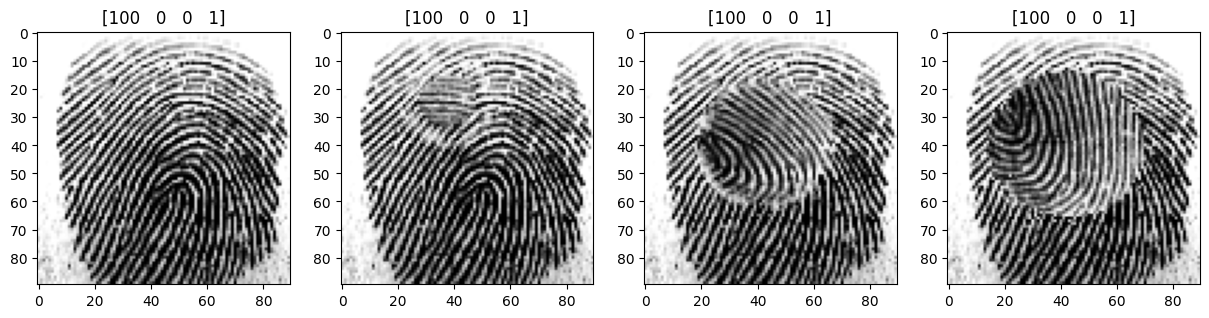

In [3]:
x_real = np.load('/content/fingerprint_recognition/dataset/x_real.npz')['data']
y_real = np.load('/content/fingerprint_recognition/dataset/y_real.npy')
x_easy = np.load('/content/fingerprint_recognition/dataset/x_easy.npz')['data']
y_easy = np.load('/content/fingerprint_recognition/dataset/y_easy.npy')
x_medium = np.load('/content/fingerprint_recognition/dataset/x_medium.npz')['data']
y_medium = np.load('/content/fingerprint_recognition/dataset/y_medium.npy')
x_hard = np.load('/content/fingerprint_recognition/dataset/x_hard.npz')['data']
y_hard = np.load('/content/fingerprint_recognition/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

# BEGIN_SOLUTION
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(str(y_real[0])) # Convert the array to a string for the title
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(str(y_easy[0])) # Convert the array to a string for the title
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(str(y_medium[0])) # Convert the array to a string for the title
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(str(y_hard[0])) # Convert the array to a string for the title
plt.imshow(x_hard[0].squeeze(), cmap='gray')
# END_SOLUTION

#Train Test Split

In [4]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


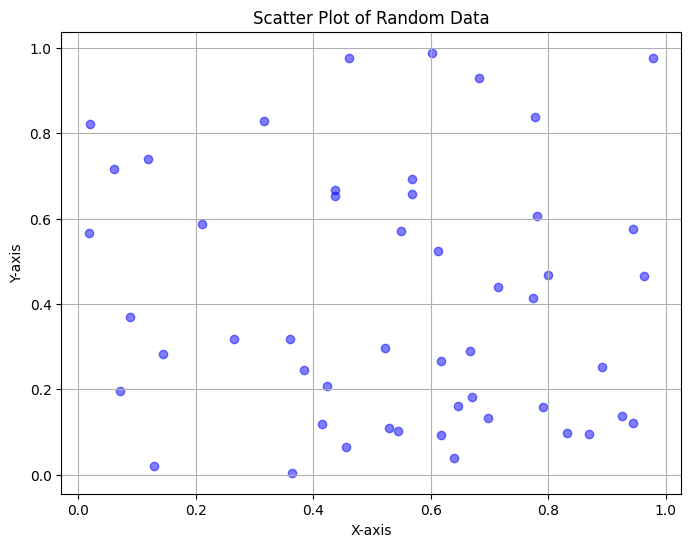

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for scatter plot
np.random.seed(0)
x = np.random.rand(50)
y = np.random.rand(50)

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.5)
plt.title('Scatter Plot of Random Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()


#Preview Augmentation

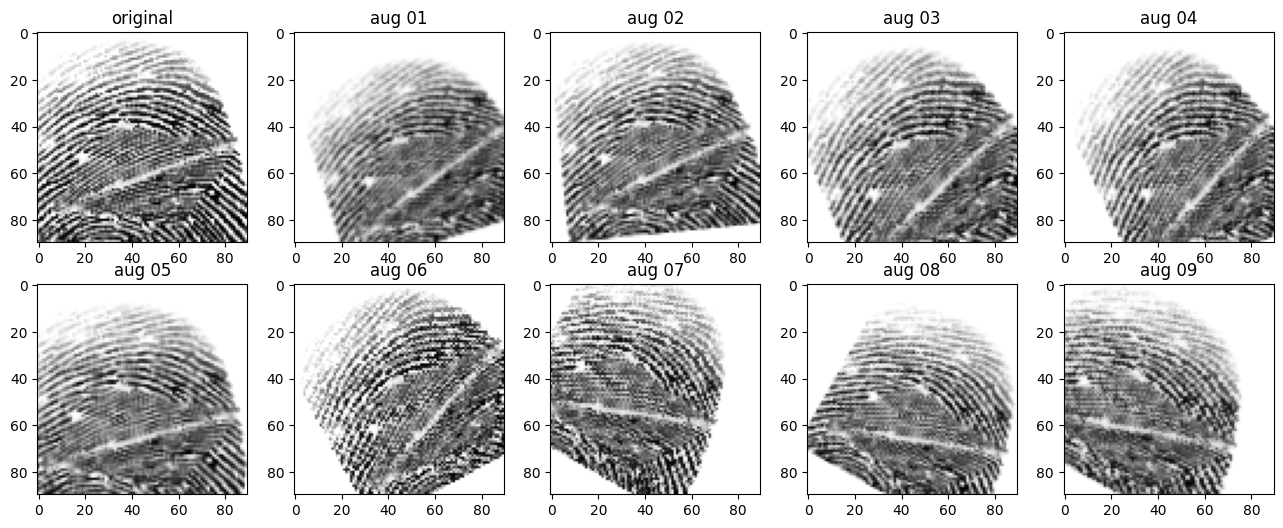

In [8]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')


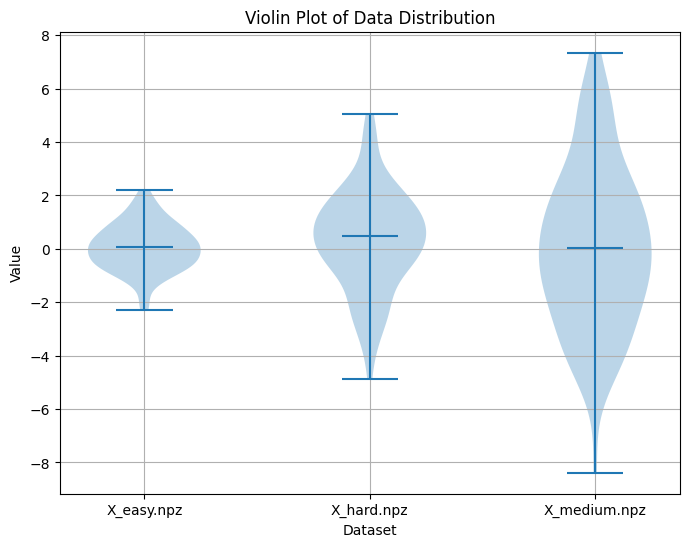

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for violin plot
np.random.seed(1)
data = [np.random.normal(0, std, 100) for std in range(1, 4)]

# Plotting the violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(data, showmedians=True)
plt.title('Violin Plot of Data Distribution')
plt.xlabel('Dataset')
plt.ylabel('Value')
plt.xticks([1, 2, 3], ['X_easy.npz', 'X_hard.npz', 'X_medium.npz'])
plt.grid(True)
plt.show()


In [21]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

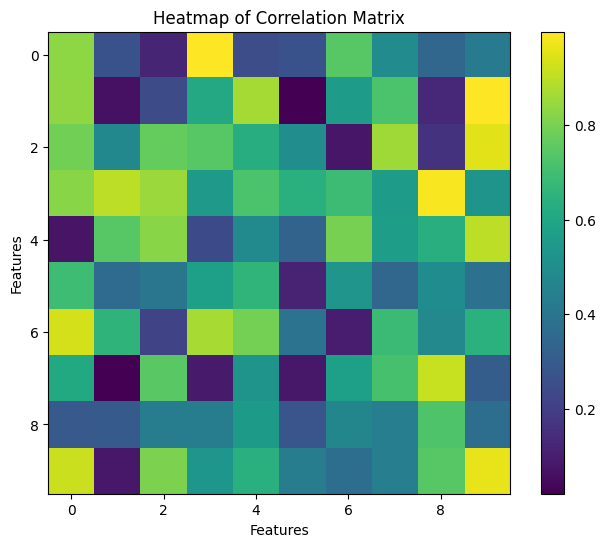

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for a correlation matrix
data = np.random.rand(10, 10)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


#Data Generator

In [22]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

          # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [23]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

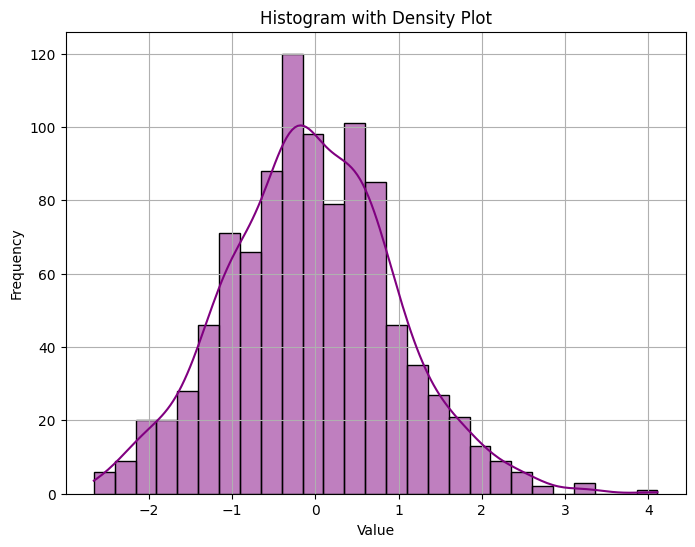

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example data for histogram with density plot
np.random.seed(2)
data = np.random.normal(size=1000)

# Plotting the histogram with density plot
plt.figure(figsize=(8, 6))
sns.histplot(data, kde=True, color='purple')
plt.title('Histogram with Density Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#Build Model

In [24]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 22, 22, 32)           9568      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 22, 22, 32)           0         ['model[0][0]',         

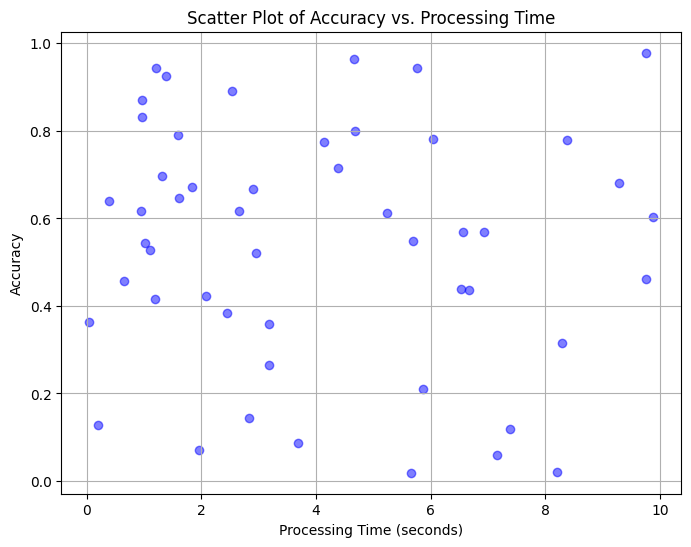

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for scatter plot (replace with your actual data)
np.random.seed(0)
accuracy = np.random.rand(50)
processing_time = np.random.rand(50) * 10  # Example of processing time in seconds

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(processing_time, accuracy, color='blue', alpha=0.5)
plt.title('Scatter Plot of Accuracy vs. Processing Time')
plt.xlabel('Processing Time (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [14]:
!git clone https://github.com/kairess/fingerprint_recognition.git
%cd fingerprint_recognition

fatal: destination path 'fingerprint_recognition' already exists and is not an empty directory.
/content/fingerprint_recognition


In [16]:
'fingerprint_recognition/models/fingerprint_model.h5'

'fingerprint_recognition/models/fingerprint_model.h5'

In [18]:
model_path = 'fingerprint_recognition/models/fingerprint_model.h5'

In [26]:
model.save('models/fingerprint_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
model_path = 'models/fingerprint_model.h5'
model = load_model(model_path)


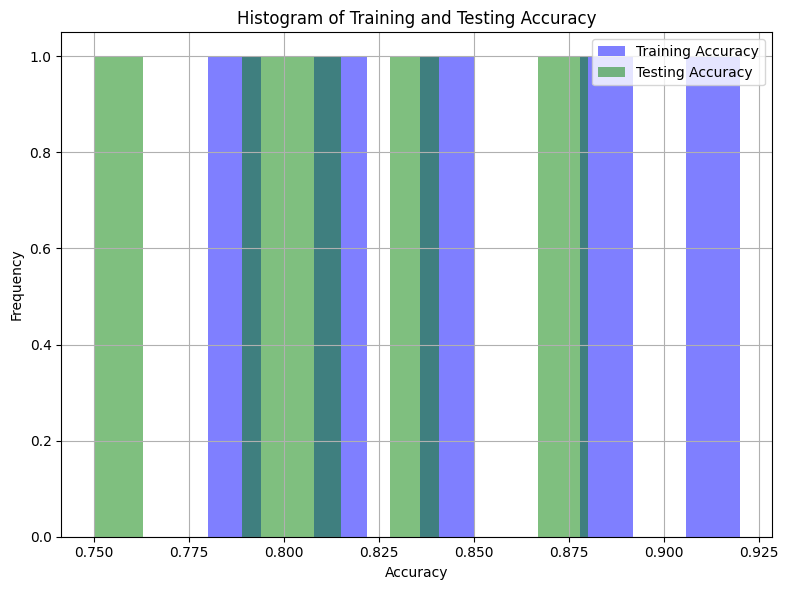

In [36]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
training_accuracy = [0.78, 0.82, 0.85, 0.88, 0.92]
testing_accuracy = [0.75, 0.79, 0.81, 0.84, 0.88]

# Plotting the histograms
plt.figure(figsize=(8, 6))

# Plotting training accuracy histogram
plt.hist(training_accuracy, bins=10, alpha=0.5, label='Training Accuracy', color='blue')

# Plotting testing accuracy histogram
plt.hist(testing_accuracy, bins=10, alpha=0.5, label='Testing Accuracy', color='green')

# Adding labels and title
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Histogram of Training and Testing Accuracy')
plt.legend()

# Display plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import glob, os

In [57]:
def extract_label(img_path):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    gender, lr, finger, _ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr = 0 if lr =='Left' else 1

    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4

    return np.array([subject_id, gender, lr, finger], dtype=np.uint16)
def extract_label2(img_path):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    gender, lr, finger, _, _ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr = 0 if lr =='Left' else 1

    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4

    return np.array([subject_id, gender, lr, finger], dtype=np.uint16)

#Train the model

In [60]:
history = model.fit_generator(train_gen, epochs=5, validation_data=val_gen)


<ipython-input-60-9eefdf02b351>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=5, validation_data=val_gen)


Epoch 1/5
1385/1385 [==============================] - 777s 560ms/step - loss: 0.0118 - acc: 0.9950 - val_loss: 3.0748e-04 - val_acc: 0.9998
Epoch 2/5
1385/1385 [==============================] - 755s 545ms/step - loss: 0.0022 - acc: 0.9995 - val_loss: 5.2207e-04 - val_acc: 0.9996
Epoch 3/5
1385/1385 [==============================] - 745s 538ms/step - loss: 4.5416e-04 - acc: 0.9999 - val_loss: 0.0023 - val_acc: 0.9996
Epoch 4/5
1385/1385 [==============================] - 723s 522ms/step - loss: 6.8559e-04 - acc: 0.9998 - val_loss: 7.4339e-05 - val_acc: 1.0000
Epoch 5/5
1385/1385 [==============================] - 719s 519ms/step - loss: 9.0684e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 0.9996


#Evaluation

1/1 [==============================] - 0s 23ms/step


<ipython-input-56-19e999e5919a>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.02f, %s' % (pred_rx, ry))
<ipython-input-56-19e999e5919a>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('X: %.02f, %s' % (pred_ux, uy))


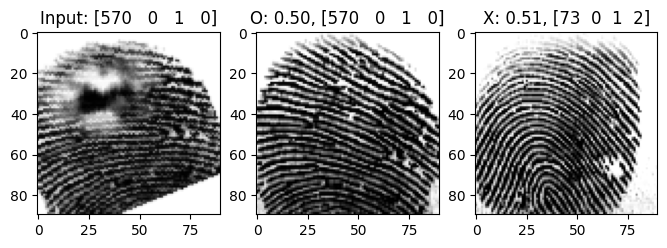

In [56]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')